In [1]:
## Importing required Libraries
import os
import tensorflow as tf
from tensorboard.plugins import projector
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import accuracy_score, f1_score

In [2]:
df = pd.read_csv("User_Journey_Based_Features.csv")

#Make categorical columns as numerical
df['weekday']=df['weekday'].replace(['Mon','Tue','Wed','Thu','Fr','Sat','Sun'],[1,2,3,4,5,6,7])
df['timeOfDay']=df['timeOfDay'].replace(['Dawn','EarlyMorning','Morning','Noon','Afternoon','Evening','Night'],[1,2,3,4,5,6,7])
print(df.shape)
df.head()

(1076360, 16)


,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,InsessionCart,InsessionView,year,month,weekday,timeOfDay,Weekend,Purchase,cluster
0,1,1,0.0,939.28,939.28,0,0,0,0,2019,11,5,2,0,1,0
1,1,1,0.0,202.30,202.30,0,0,0,0,2019,11,7,5,0,1,0
2,1,1,0.0,617.52,617.52,0,0,0,0,2019,11,5,5,0,1,0
3,1,1,0.0,89.58,89.58,0,0,0,0,2019,11,6,2,0,1,0
4,1,1,0.0,46.33,46.33,0,0,0,0,2019,11,2,2,0,1,0


In [3]:
#1. Lets find distances between clusters. Start with calinski-harabasz

In [4]:
X=np.array(df[df.columns[0:8]])
Y=np.array(df[df.columns[15]])# Y=clusterID
P=np.array(df[df.columns[14]]).astype(int)#P=purchase vs not
############################# Reduce data dimensionality to speed up label propagation
pca = PCA(n_components=5)
pca.fit(X)
X1=pca.transform(X)

print(np.shape(X1))
#start with 2 clusters to 5 and show CH score increases as clusters increase

(1076360, 5)


In [5]:
X1_n = (X1-X1.min(axis=0)) / (X1.max(axis=0)-X1.min(axis=0))
X1=X1_n
print(X1[0:5,:])

[[6.13873989e-08 4.07296854e-01 1.20025576e-02 2.63611390e-01
  3.22195130e-01]
 [1.32213735e-08 1.40100233e-01 1.20699827e-02 2.63480629e-01
  3.22235297e-01]
 [4.03584696e-08 2.90640791e-01 1.20319949e-02 2.63554301e-01
  3.22212666e-01]
 [5.85445128e-09 9.92329050e-02 1.20802953e-02 2.63460629e-01
  3.22241440e-01]
 [3.02780660e-09 8.35523521e-02 1.20842522e-02 2.63452955e-01
  3.22243797e-01]]


In [6]:
#Step 4.1: Randomly drop labels
import matplotlib.pyplot as plt
c_vals=[0,3,1,4,2] # These are cluster indices in incremental order of sample represnetation
dropP=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]#Fraction of population to be randomly dropped
acc=np.zeros((5,9,10))
f1=np.zeros((5,9,10))
for ci,item in enumerate(c_vals):
    locs=np.where(Y==item) #Locate all samples belonging to a particular cluster
    print('Processing samples of cluster=',item)
    Yn=P[locs]
    Xn=np.squeeze(X1[locs,:]) #subsample Xn from dimensionality reduced cluster features 
    n=np.shape(locs)[1]# number of samples per cluster
    ######################################################################
    #This loop needs to be rerun about 20 times each (add another loop)
    for cn in range(10):
        print(cn)
        for cp,drop in enumerate(dropP):
            Ynd=P[locs]
            ns=np.round(drop*n).astype(int)
            #print('num of samples dropped=',ns)
            dropI=np.floor(np.random.rand(ns)*n).astype(int)
            Ynd[dropI]=-1
            #Thus (Xn,Ynd) is the new data that will be subjected to label propagation
            ################################### so random label removal works!
            #Step 4.2: Apply Label propagation to all samples
            lp_model = LabelSpreading(kernel='knn',n_neighbors=3,alpha=0.1) #high alpha means labels an change till stable
            # Train the model
            lp_model.fit(Xn, Ynd)


            #Step 4.3: Predict Model label for the dropped samples
            pred = lp_model.transduction_[dropI]
            #print('Predictions=',pred)
            #print('Groundtruth=',Yn[dropI])

            #Step 4.4: Compute accuracy, for predictions
            acc[ci,cp,cn] = accuracy_score(Yn[dropI], pred)
            f1[ci,cp,cn] = f1_score(Yn[dropI], pred)

Processing samples of cluster= 0
0
1
2
3
4
5
6
7
8
9
Processing samples of cluster= 3
0
1
2
3
4
5
6
7
8
9
Processing samples of cluster= 1
0
1
2
3
4
5
6
7
8
9
Processing samples of cluster= 4
0
1
2
3
4
5
6
7
8
9
Processing samples of cluster= 2
0
1
2
3
4
5
6
7
8
9


In [7]:
a=np.mean(acc,axis=2)
f=np.mean(f1,axis=2)
print(np.shape(a))

(5, 9)


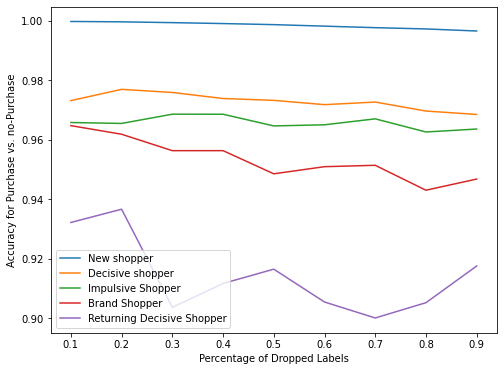

In [8]:
#Finally generate the plots per cluster
labs=['New shopper','Decisive shopper','Impulsive Shopper','Brand Shopper','Returning Decisive Shopper']
plt.figure(figsize=(8,6))
plt.plot(dropP,a[0,:])
plt.plot(dropP,a[1,:])
plt.plot(dropP,a[2,:])
plt.plot(dropP,a[3,:])
plt.plot(dropP,a[4,:])
plt.legend(labs)
plt.xlabel('Percentage of Dropped Labels')
plt.ylabel('Accuracy for Purchase vs. no-Purchase')
plt.show()



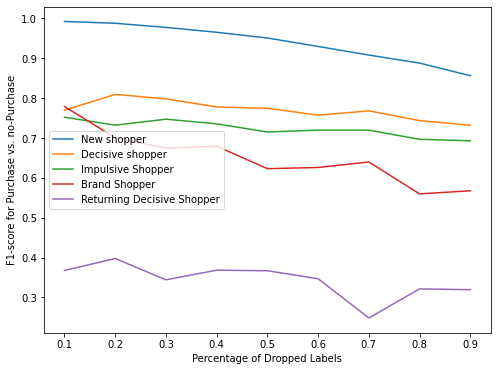

In [9]:
#Finally generate the plots per cluster
labs=['New shopper','Decisive shopper','Impulsive Shopper','Brand Shopper','Returning Decisive Shopper']
plt.figure(figsize=(8,6))
plt.plot(dropP,f[0,:])
plt.plot(dropP,f[1,:])
plt.plot(dropP,f[2,:])
plt.plot(dropP,f[3,:])
plt.plot(dropP,f[4,:])
plt.legend(labs)
plt.xlabel('Percentage of Dropped Labels')
plt.ylabel('F1-score for Purchase vs. no-Purchase')
plt.show()